# DSCI445 Term Project Paper - Bank Account Fraud Detection
### Jakob Wickham, Nick Brady, Noah Sturgeon

In [ ]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn as skim
import xgboost as xgb
import kagglehub
import seaborn as sns
import sklearn as sk

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek

## Introduction



### Motivation

One important use of statistical models is protecting customer and business interests by identifying potential fraudulent applications. In these models, there must be a balance between correctly identifying the fraud (high recall) and reducing false positives.

False positives are when legitimate applications are incorrectly flagged as fraudulent. The cost of undetected fraud has a high monetary cost to the organization. A high false positive rate can create a negative customer experience while putting additional work on support teams that must handle these verifications.

With these consequences in mind, fraud detection models must be able to detect the difference while also minimizing the negative impacts accurately.

Our goal in this project is to work with various machine learning methods to find the best model based on the following metrics:

- **Precision**: Correctly identified fraudulent cases across all *classified* fraudulent cases
- **Recall**: Correctly identified fraudulent cases across all *truly* fraudulent cases
- **F1-Score**: A metric providing a balanced measure of the harmonic mean of precision and recall
- **ROC-AUC**: Model's ability to distinguish between classes, where a higher score indicates better classification performance

We are not including accuracy as part of the metrics as while it's important to see if models can correctly identify non-fraudulent data, it does not correctly reflect the project's goals.



Reference for Text: https://seon.io/resources/dictionary/false-positives/

## Dataset overview 

For our modeling, we will be using the Bank Account Fraud NeurIPS 2022 datasets (called BAF for short), which are a suite of synthetic datasets meant to evaluate machine learning methods. The dataset has 1 million bank account instances with 31 features and the fraud_bool response for each instance.

| Variable Type  | Feature Name                  | Description                                 | Values/Range               |
|----------------|-------------------------------|---------------------------------------------|----------------------------|
| Categorical    | `payment_type`                | Credit payment plan type                    | AA to AE (5 types)         |
|                | `employment_status`           | Employment status                           | CA to CG (7 types)         |
|                | `housing_status`              | Residential status                          | BA to BG (7 types)         |
|                | `source`                      | Application source                          | INTERNET, TELEAPP          |
|                | `device_os`                   | Device operating system                     | Windows, macOS, Linux, X11, other |
| Numeric        | `income`                      | Annual income in quantiles                  | 0.1 to 0.9                 |
|                | `name_email_similarity`       | Email and name similarity                   | 0 to 1                     |
|                | `prev_address_months_count`*  | Months at previous address                  | 0 to 380, -1 = missing     |
|                | `current_address_months_count`* | Months at current address                   | 0 to 429, -1 = missing     |
|                | `customer_age`                | Age in years (rounded to decade)            | 10 to 90                   |
|                | `days_since_request`          | Days since request                          | 0 to 79                    |
|                | `intended_balcon_amount`*     | Initial amount transferred                  | 0 to 114, -1 to -16 = missing |
|                | `zip_count_4w`                | Applications in same zip (last 4 weeks)     | 1 to 6830                  |
|                | `velocity_6h`                 | Apps per hour (last 6 hrs)                  | -175 to 16818              |
|                | `velocity_24h`                | Apps per hour (last 24 hrs)                 | 1297 to 9586               |
|                | `velocity_4w`                 | Apps per hour (last 4 weeks)                | 2825 to 7020               |
|                | `bank_branch_count_8w`        | Branch apps (last 8 weeks)                  | 0 to 2404                  |
|                | `date_of_birth_distinct_emails_4w` | Distinct emails with same DOB (last 4 weeks) | 0 to 39                  |
|                | `credit_risk_score`           | Internal risk score                         | -191 to 389                |
|                | `bank_months_count`*          | Months of previous account                  | 0 to 32, -1 = missing      |
|                | `proposed_credit_limit`       | Proposed credit limit                       | 200 to 2000                |
|                | `session_length_in_minutes`*  | Session length on website                   | 0 to 107, -1 = missing     |
|                | `device_distinct_emails_8w`*  | Distinct emails for device (last 8 weeks)   | 0 to 2, -1 = missing       |
|                | `device_fraud_count`          | Fraud count for device                      | All values = 0             |
|                | `month`                       | Application month                           | 0 to 7                     |
| Binary         | `email_is_free`               | Free email domain                           | 0 or 1                     |
|                | `phone_home_valid`            | Home phone validity                         | 0 or 1                     |
|                | `phone_mobile_valid`          | Mobile phone validity                       | 0 or 1                     |
|                | `has_other_cards`             | Other cards with bank                       | 0 or 1                     |
|                | `foreign_request`             | Request from foreign country                | 0 or 1                     |
|                | `keep_alive_session`          | "Remember me" enabled                       | 0 or 1                     |

\* Negative values indicate missing data for these variables.


## Methodolgy

### Data Preprocessing 

In [8]:
# Only run if you want to locally have the dataset on your machine
path = kagglehub.dataset_download("sgpjesus/bank-account-fraud-dataset-neurips-2022")

data: pd.DataFrame = pd.read_csv(f"{path}/Base.csv")

Our first step was the data-cleaning process. At first glance, no columns had missing data. However, a unique attribute of the BAF is that certain numeric columns had negative values that signify missing values. Inspection of those columns was required to determine their data quality.

After that inspection, a decision had to be made about dealing with the missing data: either removing the column entirely from the model or imputing the data.

The decision on what columns had to be removed was determined by calculating the percentage of each feature with missing values and removing the columns over a threshold of 50%. As shown by the table below. Imputing data over that threshold can add bias to our model. 

Imputation was applied to the columns below the threshold. Imputation is the process of filling the missing values with reasonable values. In this data set, the median value was used. For our model to know the difference between values that were imputed or not, we created an additional column _is_imputed so our model can determine if they were imputed or not.

During the initial process, we found that device_fraud_count has only 0 in its column, which did not provide any meaning, so we dropped that column from the dataset.


Reference to Text: https://scikit-learn.org/1.5/modules/impute.html

In [9]:
numeric_missing_value_columns = [
    'prev_address_months_count',
    'current_address_months_count',
    'intended_balcon_amount', 
    'bank_months_count', 
    'session_length_in_minutes', 
    'device_distinct_emails_8w'
]

# Create a summary DataFrame for missing data
missing_data_summary = pd.DataFrame({
    'Percentage Missing': [(data[col] < 0).mean() * 100 for col in numeric_missing_value_columns]
}, index=numeric_missing_value_columns).sort_values(by='Percentage Missing', ascending=False)

missing_data_summary


,Percentage Missing
intended_balcon_amount,74.2523
prev_address_months_count,71.2920
bank_months_count,25.3635
current_address_months_count,0.4254
session_length_in_minutes,0.2015
device_distinct_emails_8w,0.0359


In [10]:
cleaned_data = data.copy()

# Removing the 'device_fraud_count' column due to it only containing one value
cleaned_data = cleaned_data.drop('device_fraud_count', axis=1)

# Removing the 'prev_address_months_count' and 'intended_balcon_amount' columns due to high missing data
cleaned_data = cleaned_data.drop(['prev_address_months_count', 'intended_balcon_amount'], axis=1)

# List of columns to impute 
columns_to_impute = [
    "current_address_months_count", 
    "bank_months_count", 
    "session_length_in_minutes", 
    "device_distinct_emails_8w"
]

# Impute missing values and create an is_imputed flag
for col in columns_to_impute:
    imputed_flag_col = f"{col}_is_imputed"
    # Create a flag column to indicate imputed values
    cleaned_data[imputed_flag_col] = cleaned_data[col] < 0
    # Impute missing values (negative values treated as missing) with the median
    median_value = cleaned_data.loc[cleaned_data[col] >= 0, col].median()
    cleaned_data[col] = cleaned_data[col].where(cleaned_data[col] >= 0, median_value)

# List of nominal categorical columns to one-hot encode
nominal_categorical_columns = [
    'payment_type', 
    'employment_status', 
    'housing_status', 
    'source', 
    'device_os'
]

# One-hot encode nominal categorical columns and overwrite cleaned_data
cleaned_data = pd.get_dummies(
    cleaned_data, 
    columns=nominal_categorical_columns, 
    drop_first=True
)


### Exploratory Data Analysis

Since the data cleaning process was completed, we looked at the remaining columns to see if there were any clues or indicators of what could determine fraudulent applications. Before, we looked at the categorical, numeric, and binary Predictors separately. We first looked at how many fraud cases we had in the data set and what percentage, as shown below. With the number of fraud cases being so imbalanced, we will need to understand the effect of the imbalance and how to address it.

In [11]:

fraud_counts = cleaned_data['fraud_bool'].value_counts().reset_index()
fraud_counts.columns = ['Fraudulent Status', 'Count']
fraud_counts['Fraudulent Status'] = fraud_counts['Fraudulent Status'].replace({0: 'Non-Fraudulent', 1: 'Fraudulent'})


total_count = fraud_counts['Count'].sum()
fraud_counts['Percentage'] = (fraud_counts['Count'] / total_count) * 100


fraud_counts


,Fraudulent Status,Count,Percentage
0,Non-Fraudulent,988971,98.8971
1,Fraudulent,11029,1.1029


Our exploratory data analysis and correlation matrix showed insights into key predictors that can determine fraud. Those insights allowed us to perform feature engineering before model selection to help our model accurately classify our objective. When we performed a summary of statistics on numeric features for fraud and non-fraud cases (See Table #1), it showed us higher fraud rates for income, proposed_credit_limit, and customer age. When we performed a Fraud Rate by numeric features binned (See Table #2), it confirmed those claims with 13% fraud rates for people requesting credit limits above $1500 and 4.2% for people over 60. When completing a Fraud Analysis by Categorical Features (See Table #3), payment types like AC (1.75%) and BA (3.75%) were indicators of fraudulent activity. Our Analysis for Binary Features ( See table #4 ) showed us that identity and foreign_request (2.2%) were also fraud indicators. The correlation matrix (See Table #5) confirmed our finding when looking at the predictors separately. Still, there is high collinearity due to the time series' relation to each other, and some, like days_since_request, showed weaker correlations for limited predictive potential. Initially, we created feature engineering to create high-risk flags and risk categories based on this known information, but they failed to improve model performance which will be discussed further in the analysis.



In [ ]:
'''TABLE #1'''

numerical_features = [
    "income", "name_email_similarity", "current_address_months_count",
    "customer_age", "days_since_request", "zip_count_4w", "velocity_6h",
    "velocity_24h", "velocity_4w", "bank_branch_count_8w",
    "date_of_birth_distinct_emails_4w", "credit_risk_score", 
    "bank_months_count", "proposed_credit_limit", "session_length_in_minutes",
    "device_distinct_emails_8w", "month"
]

# Create a summary table for distribution of numeric features by fraud status
distribution_table = []

for feature in numerical_features:
    # Descriptive statistics for Legit (0)
    legit_data = cleaned_data[cleaned_data['fraud_bool'] == 0][feature]
    legit_count = legit_data.count()
    legit_mean = legit_data.mean()
    legit_std = legit_data.std()

    # Descriptive statistics for Fraud (1)
    fraud_data = cleaned_data[cleaned_data['fraud_bool'] == 1][feature]
    fraud_count = fraud_data.count()
    fraud_mean = fraud_data.mean()
    fraud_std = fraud_data.std()

    # Append to table
    distribution_table.append({
        'Feature': feature,
        'Legit_Count': legit_count,
        'Legit_Mean': legit_mean,
        'Legit_Std': legit_std,
        'Fraud_Count': fraud_count,
        'Fraud_Mean': fraud_mean,
        'Fraud_Std': fraud_std
    })

# Convert to a DataFrame
distribution_table_df = pd.DataFrame(distribution_table)

# Display the table
distribution_table_df


,Feature,Legit_Count,Legit_Mean,Legit_Std,Fraud_Count,Fraud_Mean,Fraud_Std
0,income,988971,0.561313,0.290309,11029,0.686635,0.265579
1,name_email_similarity,988971,0.494815,0.288855,11029,0.393161,0.295607
2,current_address_months_count,988971,86.504746,88.231333,11029,114.869707,85.252948
3,customer_age,988971,33.609125,11.989302,11029,40.858645,13.086334
4,days_since_request,988971,1.025383,5.378088,11029,1.054615,5.707977
5,zip_count_4w,988971,1572.138693,1005.357780,11029,1622.311542,1005.687071
6,velocity_6h,988971,5670.664988,3010.120768,11029,5183.913444,2902.298679
7,velocity_24h,988971,4771.528849,1479.588964,11029,4613.138798,1436.521551
8,velocity_4w,988971,4857.444566,919.140920,11029,4755.844185,975.663156
9,bank_branch_count_8w,988971,184.923747,460.054059,11029,133.976426,416.350611


In [ ]:
'''TABLE #2'''

# Function to create bins and calculate fraud percentage within each bin
def calculate_fraud_percentage(data, feature, bins):
    data['binned'] = pd.cut(data[feature], bins=bins, include_lowest=True)
    # Check for unbinned data
    unbinned_count = data['binned'].isnull().sum()
    if unbinned_count > 0:
        print(f"Warning: {unbinned_count} rows for feature '{feature}' are unbinned.")

    fraud_percentage = data.groupby('binned', observed=True)['fraud_bool'].mean() * 100
    count = data['binned'].value_counts()
    result = pd.DataFrame({'Count': count, 'Fraud Percentage (%)': fraud_percentage}).sort_index()
    return result

# Define bins for each numerical feature (using quantiles or custom ranges for meaningful distribution)
bin_edges = {
    "income": [0.1, 0.3, 0.5, 0.7, 0.85, 0.9],  # Merged empty bin (0.8–0.85) into adjacent bins
    "name_email_similarity": [0, 0.2, 0.4, 0.6, 0.8, 1],  # No change; bins are consistent
    "current_address_months_count": [0, 50, 100, 150, 200, 450],  # Simplified by merging sparse ranges
    "customer_age": [10, 20, 30, 40, 50, 60, 100],  # Merged sparse bins (60–70 and 70–100)
    "days_since_request": [0, 5, 10, 20, 30, 80],  # Combined sparse bins (30–50, 50–80)
    "zip_count_4w": [1, 500, 1000, 2000, 3000, 7000],  # Merged sparse ranges for higher bins
    "velocity_6h": [-200, 1000, 2000, 4000, 10000, 17000],  # Merged mid-range bins for better coverage
    "velocity_24h": [1299.8, 2000, 3000, 4000, 7000, 9500],  # Merged sparse bins for `3000–5000`
    "velocity_4w": [2799.8, 3500, 4000, 6000, 7000],  # Combined sparse bins for lower velocities
    "bank_branch_count_8w": [0, 2, 5, 10, 50, 500, 2500],  # Merged sparse higher ranges
    "date_of_birth_distinct_emails_4w": [0, 2, 5, 10, 15, 25, 40],  # Combined sparse bins in high counts
    "credit_risk_score": [-200, 0, 50, 100, 150, 200, 300, 400],  # Adjusted high-risk bins for better granularity
    "bank_months_count": [0, 5, 10, 15, 20, 30, 35],  # Merged sparse bins (25–30, 30–35)
    "proposed_credit_limit": [200, 300, 500, 1000, 1500, 2000, 2100],  # Merged empty and sparse bins
    "session_length_in_minutes": [0, 2, 5, 10, 20, 30, 90],  # Merged sparse bins for long sessions
    "device_distinct_emails_8w": [0, 1, 2],  # Removed empty bins (1.0–1.2, 1.2–1.5)
    "month": [0, 1, 2, 3, 4, 5, 6, 8]  # Merged sparse and empty bins for later months
}


# Calculate and print fraud percentage within bins for each feature
for feature, bins in bin_edges.items():
    result = calculate_fraud_percentage(cleaned_data, feature, bins)
    print(f"Fraud Analysis for Feature: {feature}")
    print(result)
    print("\n")

# Clean up 'binned' column after use
if 'binned' in cleaned_data.columns:
    cleaned_data = cleaned_data.drop(columns=['binned'])


Fraud Analysis for Feature: income
               Count  Fraud Percentage (%)
binned                                    
(0.099, 0.3]  277627              0.606929
(0.3, 0.5]    137222              0.758625
(0.5, 0.7]    111973              0.877890
(0.7, 0.85]   251759              1.004532
(0.85, 0.9]   221419              2.163771


Fraud Analysis for Feature: name_email_similarity
                Count  Fraud Percentage (%)
binned                                     
(-0.001, 0.2]  221045              1.906399
(0.2, 0.4]     187215              1.177256
(0.4, 0.6]     202019              0.696469
(0.6, 0.8]     184805              0.878223
(0.8, 1.0]     204916              0.771536


Fraud Analysis for Feature: current_address_months_count
                 Count  Fraud Percentage (%)
binned                                      
(-0.001, 50.0]  484782              0.524772
(50.0, 100.0]   194878              1.677973
(100.0, 150.0]  111417              2.039186
(150.0, 200.0]   968

In [ ]:
'''TABLE #3'''

categorical_features = [
    'payment_type', 'employment_status', 'housing_status',
    'source', 'device_os'
]

# Function to calculate fraud rates by category
def calculate_category_fraud(data, feature):
    category_fraud_rate = data.groupby(feature)['fraud_bool'].mean() * 100
    count = data[feature].value_counts()
    result = pd.DataFrame({'Count': count, 'Fraud Percentage (%)': category_fraud_rate}).sort_index()
    return result

# Calculate and display fraud percentage for each categorical feature
for feature in categorical_features:
    result = calculate_category_fraud(cleaned_data, feature)
    print(f"Fraud Analysis for Feature: {feature}")
    print(result)
    print("\n")


Fraud Analysis for Feature: payment_type
               Count  Fraud Percentage (%)
payment_type                              
AA            258249              0.528172
AB            370554              1.125072
AC            252071              1.669768
AD            118837              1.082155
AE               289              0.346021


Fraud Analysis for Feature: employment_status
                    Count  Fraud Percentage (%)
employment_status                              
CA                 730252              1.218620
CB                 138288              0.689142
CC                  37758              2.468351
CD                  26522              0.377045
CE                  22693              0.233552
CF                  44034              0.193033
CG                    453              1.545254


Fraud Analysis for Feature: housing_status
                 Count  Fraud Percentage (%)
housing_status                              
BA              169675              3.74657

-Free email domains, invalid phone numbers, and foreign requests show significantly higher fraud rates
-applicants without other cards and non-remembered sessions are correlated with increased fraud

In [ ]:
'''TABLE #4'''

# Define binary predictors
binary_predictors = [
    "email_is_free",
    "phone_home_valid",
    "phone_mobile_valid",
    "has_other_cards",
    "foreign_request",
    "keep_alive_session"
]

# Create an empty list to store the analysis
binary_analysis = []

# Loop through each binary predictor and calculate distribution and fraud percentage
for predictor in binary_predictors:
    # Count the number of True and False values
    true_count = cleaned_data[predictor].sum()
    false_count = len(cleaned_data) - true_count
    
    # Calculate fraud percentage for True and False
    fraud_true = cleaned_data[(cleaned_data[predictor] == 1) & (cleaned_data['fraud_bool'] == 1)].shape[0]
    fraud_false = cleaned_data[(cleaned_data[predictor] == 0) & (cleaned_data['fraud_bool'] == 1)].shape[0]
    
    fraud_percentage_true = (fraud_true / true_count) * 100 if true_count > 0 else 0
    fraud_percentage_false = (fraud_false / false_count) * 100 if false_count > 0 else 0
    
    # Append results to the analysis list
    binary_analysis.append({
        "Feature": predictor,
        "Count_True": true_count,
        "Fraud_Percentage_True": fraud_percentage_true,
        "Count_False": false_count,
        "Fraud_Percentage_False": fraud_percentage_false
    })

# Convert the analysis into a DataFrame
binary_analysis_df = pd.DataFrame(binary_analysis)

# Display the analysis
binary_analysis_df


,Feature,Count_True,Fraud_Percentage_True,Count_False,Fraud_Percentage_False
0,email_is_free,529886,1.375956,470114,0.795126
1,phone_home_valid,417077,0.669181,582923,1.413223
2,phone_mobile_valid,889676,1.054429,110324,1.493782
3,has_other_cards,222988,0.417511,777012,1.299594
4,foreign_request,25242,2.198716,974758,1.074523
5,keep_alive_session,576947,0.653093,423053,1.716333


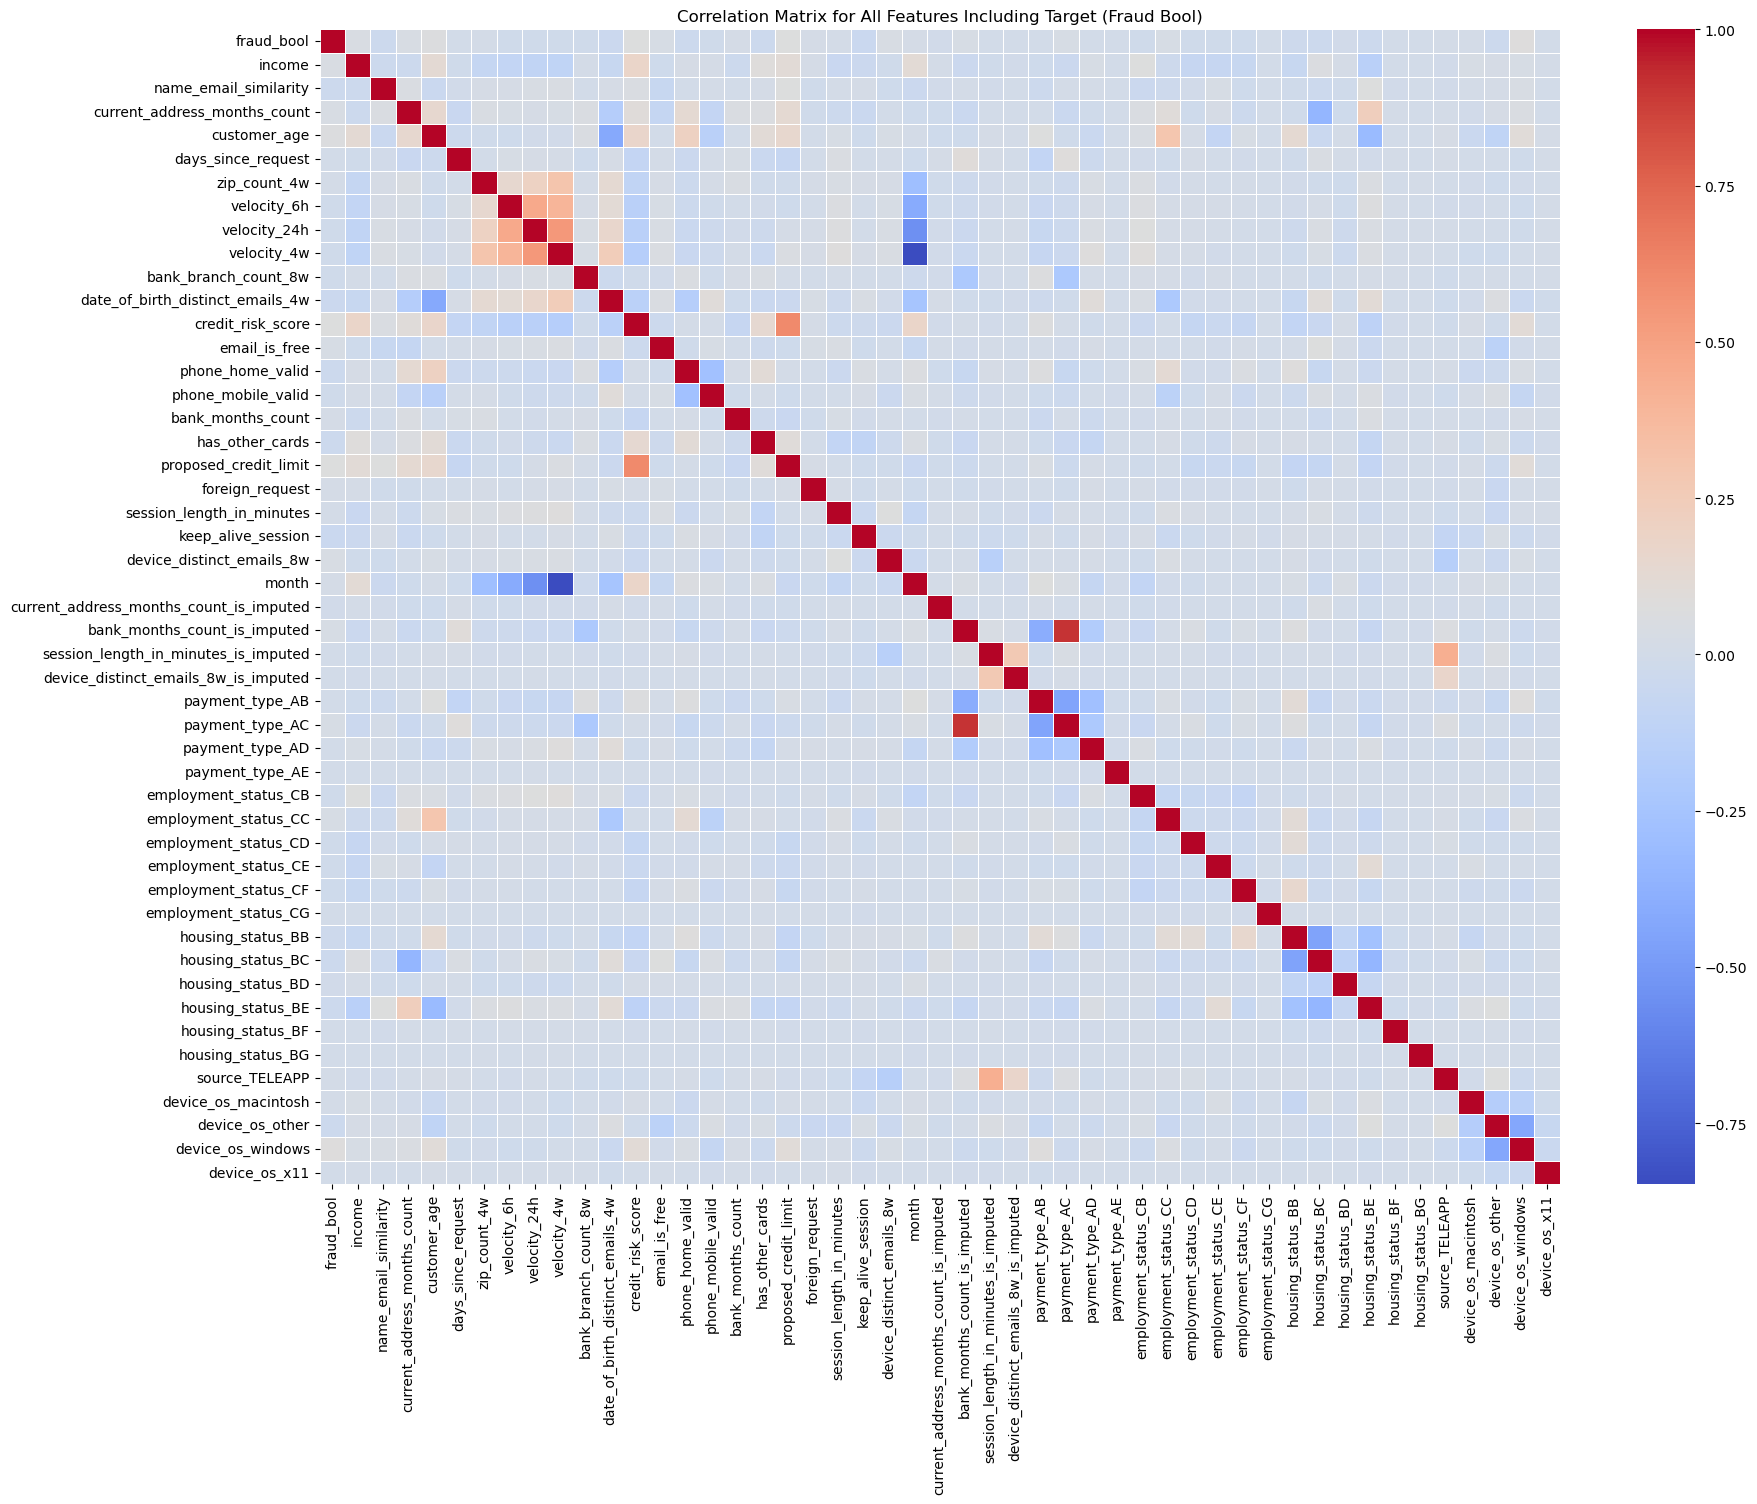

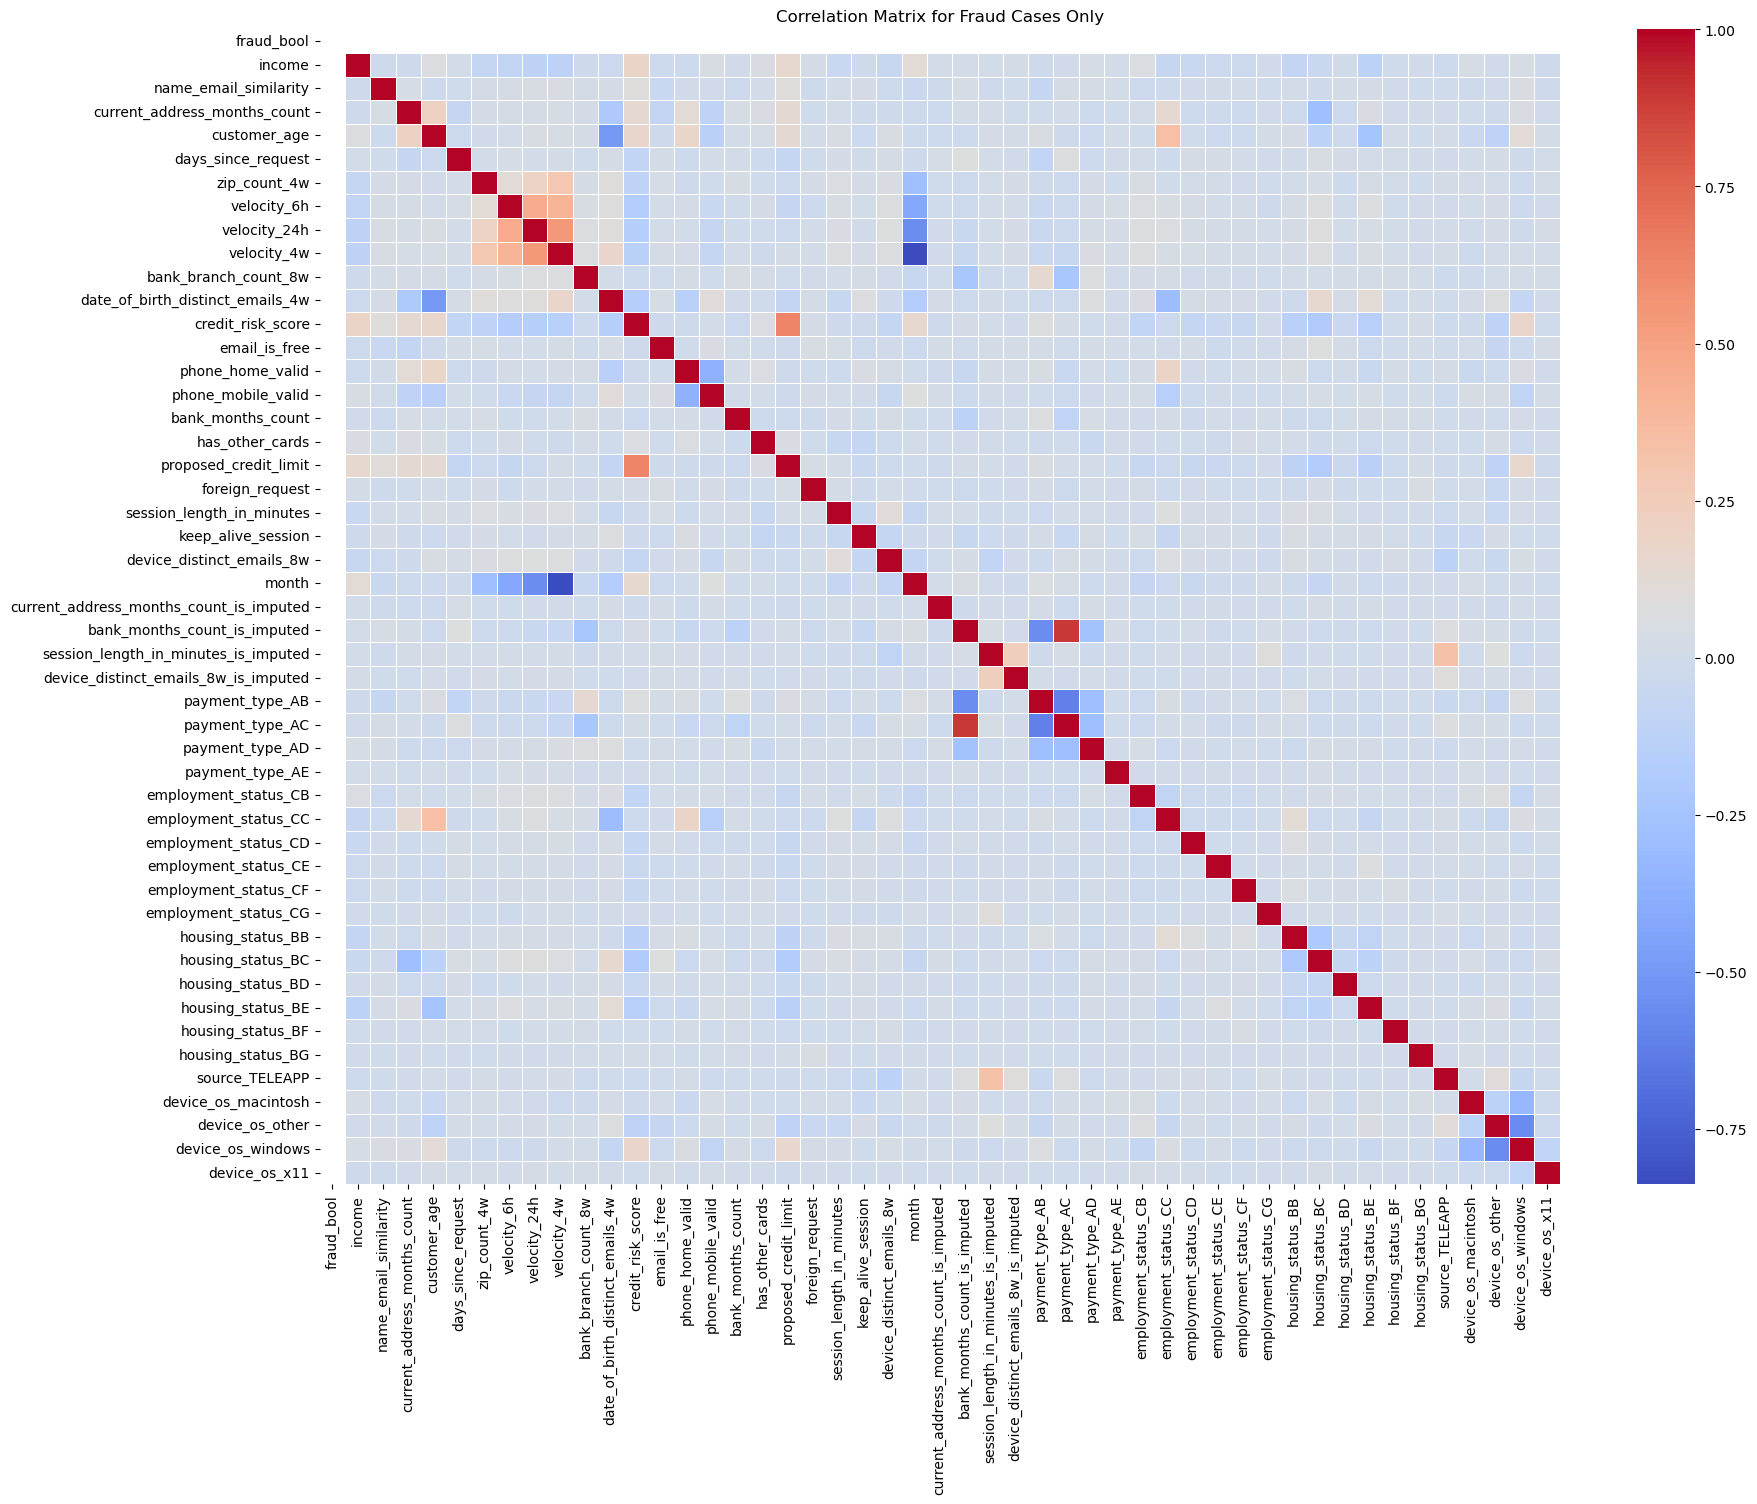

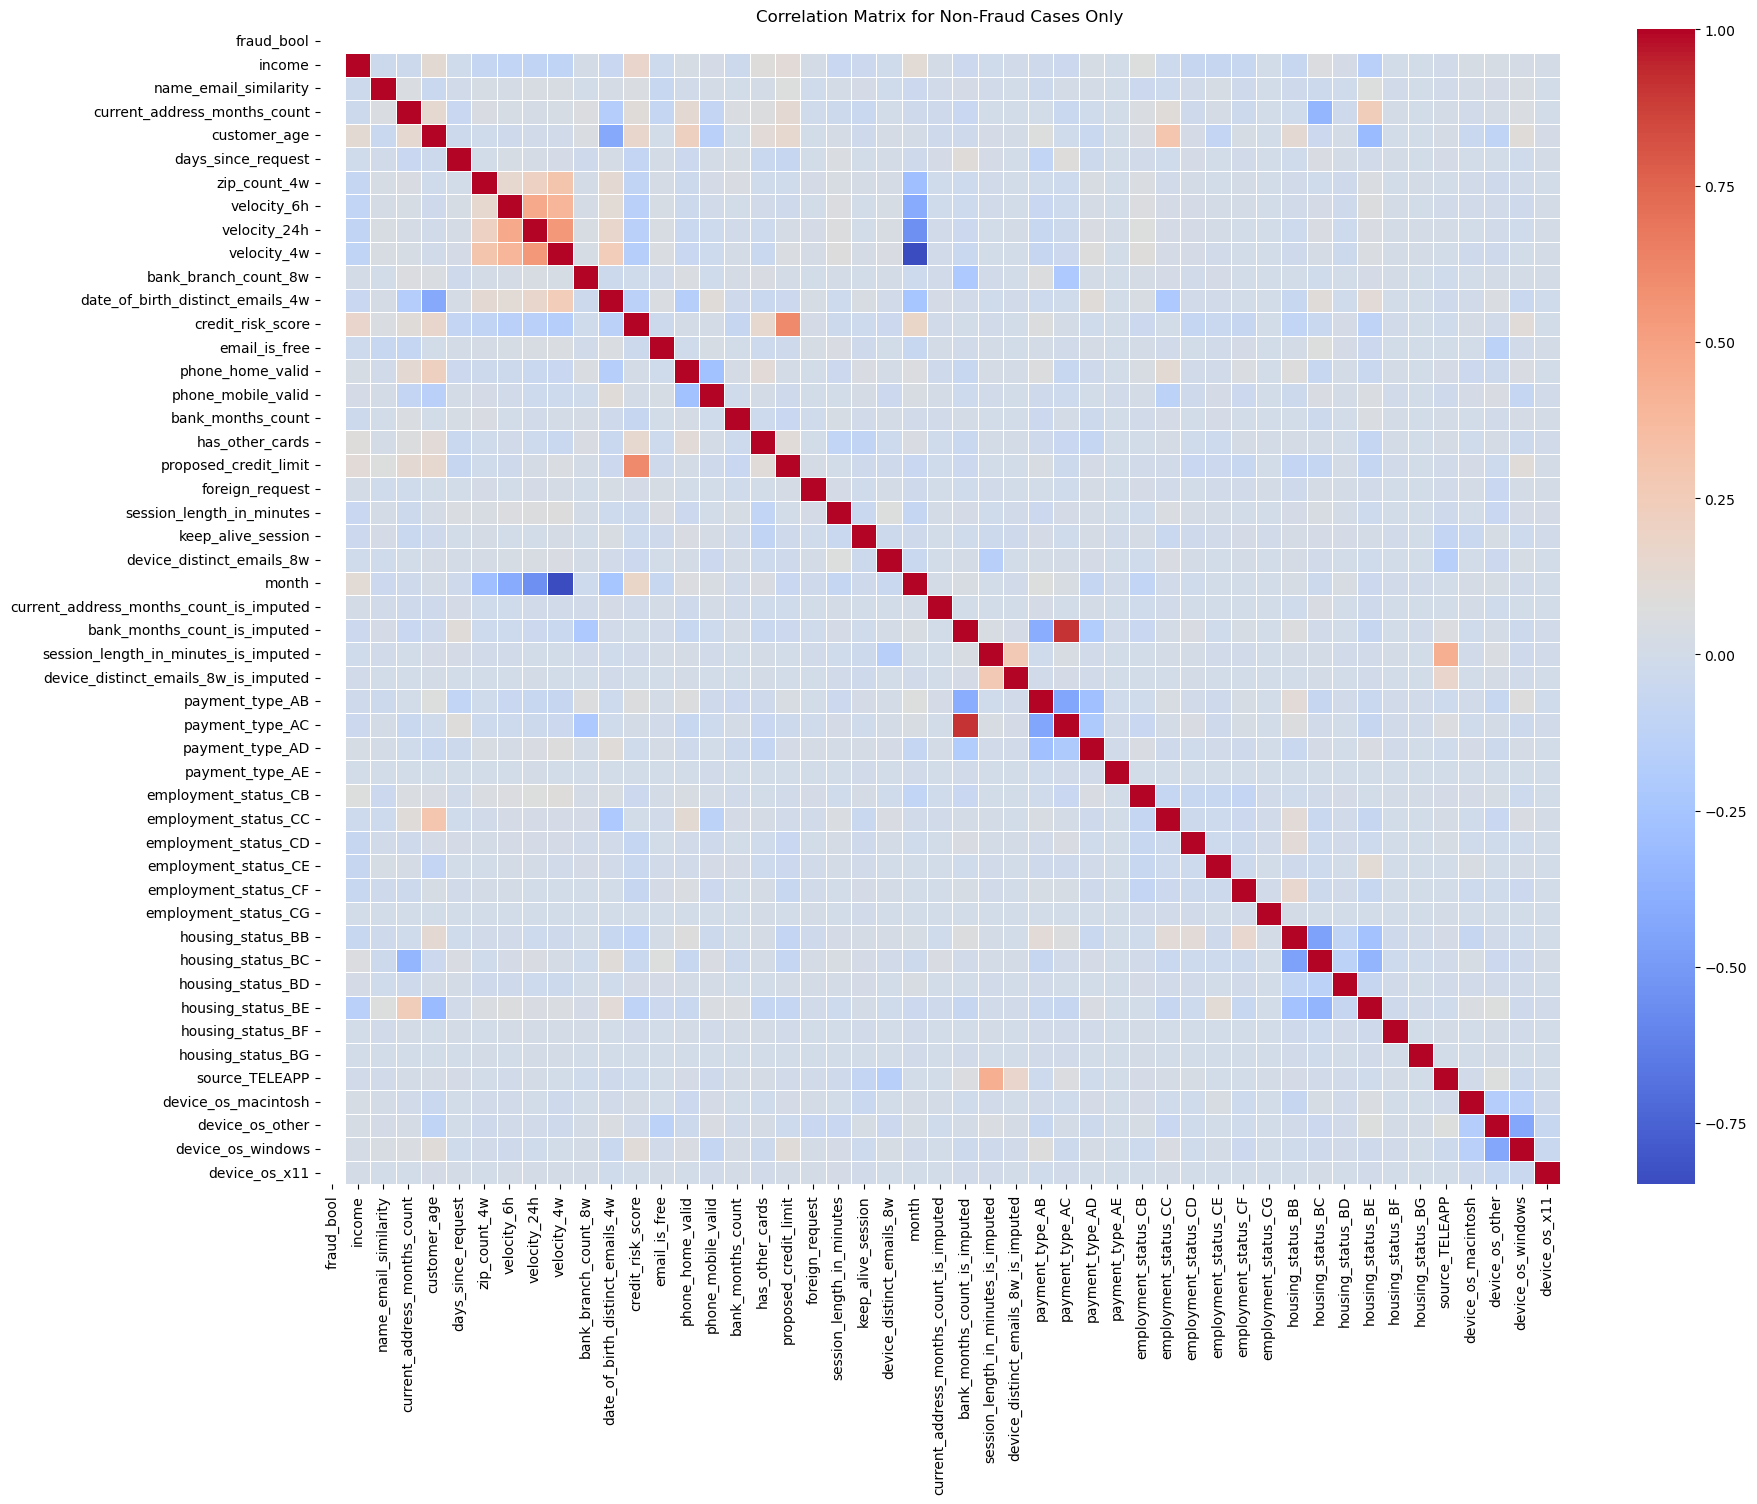

In [ ]:
'''TABLE #5'''

# Step 1: Correlation Matrix for All Data
plt.figure(figsize=(20, 15))
correlation_matrix = cleaned_data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for All Features Including Target (Fraud Bool)')
plt.show()

# Step 2: Fraud vs. Non-Fraud Correlation
# Fraud Cases Only
plt.figure(figsize=(20, 15))
fraud_corr = cleaned_data[cleaned_data['fraud_bool'] == 1].corr()
sns.heatmap(fraud_corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Fraud Cases Only')
plt.show()

# Non-Fraud Cases Only
plt.figure(figsize=(20, 15))
nonfraud_corr = cleaned_data[cleaned_data['fraud_bool'] == 0].corr()
sns.heatmap(nonfraud_corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Non-Fraud Cases Only')
plt.show()


## Naive Approach

In [ ]:
y = cleaned_data['fraud_bool']
X = pd.get_dummies(cleaned_data.drop('fraud_bool', axis=1), drop_first=True)
X = StandardScaler().fit_transform(X) # This normalizes the predictors

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=445)

{talk about the naive approach to the problem: using the dataset as is into some models, the results, why it performed horribly}

After cleaning up our dataset and doing EDA to check if there were any correlations or predictors that may stand out to help us work with our models, ultimately nothing of much use came out from it, so we decided to jump straight to model creating. The first idea we decided to check out was our "control" models: if we did nothing to handle the imbalanced data and instead throw it into some models, how would those models perform? This is the naive approach that we took a look at.

We selected 4 models for our control group: logistic regression, K-nearest neighbors, decision tree, and a random forest of 100 trees. We looked into doing more complex models such as support vector machines or possibly any unsupervised models, but with our million row and 30-something feature dataset, these models would take a long time to calculate, so we decided to have the random forest be our most complex model for our control group.

Below is the results of the naive approach alongside an interpolated recall score if the model had a 5% false positive rate (FPR).

In [ ]:
def calculate_metrics(model, X_test, y_test, sampling_method=None):
    """Calculate evaluation metrics for a given model."""
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Calculate global metrics
    results = {
        'Model': model.__class__.__name__,
        'Sampling Method': sampling_method if sampling_method else 'Original Data',
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'ROC-AUC': roc_auc_score(y_test, prob)
    }

    # Confusion Matrix Derived FPR
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    global_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    results['FPR'] = global_fpr

    # Calculate Recall @5% FPR
    fpr, tpr, _ = roc_curve(y_test, prob)
    recall_at_5_fpr = np.interp(0.05, fpr, tpr)  # Interpolates Recall at 5% FPR
    results['Recall @5% FPR'] = recall_at_5_fpr

    return results

In [ ]:
logreg = LogisticRegression(solver="newton-cholesky").fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
decision = DecisionTreeClassifier(criterion="gini").fit(X_train, y_train)
forest = RandomForestClassifier(n_estimators=100, criterion="gini").fit(X_train, y_train)

logreg_results = calculate_metrics(logreg, X_test, y_test)
knn_results = calculate_metrics(knn, X_test, y_test)
decision_results = calculate_metrics(decision, X_test, y_test)
forest_results = calculate_metrics(forest, X_test, y_test)

results_df = pd.DataFrame([logreg_results, knn_results, decision_results, forest_results])

# Display results
print(results_df)

#### to-do: figure out how to fix this table, because it's not looking good in the paper

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Model</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
      <th>ROC-AUC</th>
      <th>FPR</th>
      <th>Recall @5% FPR</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>LogisticRegression</td>
      <td>0.447368</td>
      <td>0.007665</td>
      <td>0.015071</td>
      <td>0.872193</td>
      <td>0.000106</td>
      <td>0.504959</td>
    </tr>
    <tr>
      <td>KNeighborsClassifier</td>
      <td>0.150000</td>
      <td>0.001353</td>
      <td>0.002681</td>
      <td>0.660778</td>
      <td>0.000086</td>
      <td>0.294612</td>
    </tr>
    <tr>
      <td>DecisionTreeClassifier</td>
      <td>0.083089</td>
      <td>0.102344</td>
      <td>0.091717</td>
      <td>0.544839</td>
      <td>0.012665</td>
      <td>0.136288</td>
    </tr>
    <tr>
      <td>RandomForestClassifier</td>
      <td>0.428571</td>
      <td>0.001353</td>
      <td>0.002697</td>
      <td>0.819742</td>
      <td>0.000020</td>
      <td>0.439317</td>
    </tr>
  </tbody>
</table>
</div>

As expected, these models did not have good recall rates, but the false positive rates were pretty low for all of them--some of them could even be considered 0%. The only useful thing to take away from this is that last column: a higher FPR somehow results in a higher recall rate, and seeing this trend later on has caused us some trouble with our original 5% FPR restriction, leading us to scrap it. We had to deal with this recall rate / false positive rate balance throughout our project to ensure that our model was predicting fraud data as best as it could while also not incorrectly predicting fraud data frequently, which was a pain to deal with for hyperparameter tuning.

The reason behind the recall rate and false positive rate having some kind of influence on each other is simple: because our data is imbalanced, we're trying to make our models have a better chance of predicting a fraudulent transaction--which'll increase recall--but in turn, it'll increase the chance the model incorrectly predicts a non-fraudulent transaction as fraudulent, increasing the false positive rate. If we fix the FPR, the model will be more conservative and predict less fraudulent transactions, resulting in the possibility of fraudulent transactions being predicted as non-fraudulent, which is very bad.

Having a high FPR may seem scary, but in the case of fraud detection, it's actually better to have that than a lower recall rate. If a fraud detector predicts that a legitimate transaction was fraudulent (a false positive), the worst case scenario is the company loses a customer. If a fraud detector predicts that a fraudulent transaction was legitimate (a false negative), the worst case scenario is the person lost money and has to file a dispute to try and get their money back. So in our project, which deals with fraud detection, we decided that it was better risking our models having a high recall rate and FPR than trying to stay below our 5% FPR restriction and having a low recall rate because of it.

## Imbalanced Data Handling

### Sampling Techniques

{talk about each of the four methods we tried: SMOTE, ADASYN, Under-sampling, SMOTE + Tomek's Links; how each of these could help improve performance for imbalanced data, and the results we got using those techniques for each model(?)}

### Imbalanced Models

{talk about the two imbalanced models we tried: Balanced Forest and XGBoost, how each of these could help improve performance for imbalanced data, and the results we got using those models on the various techniques(?)}

## Conclusion

{talk about what we got out of the results, why the recall-FPR tradeoff is important in fraud detection, what we tried and failed, and what we could've done differently}

#### ----------------------------------------------------------------------------

In [ ]:
# Define features and target for cleaned data
X_cleaned = cleaned_data.drop(columns=["fraud_bool"])  # Features
y_cleaned = cleaned_data["fraud_bool"]  # Target

# Train-test split for cleaned data
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, y_cleaned, test_size=0.3, random_state=42, stratify=y_cleaned
)

# 1. Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_cleaned_smote, y_train_cleaned_smote = smote.fit_resample(X_train_cleaned, y_train_cleaned)

# 2. Initialize and train Logistic Regression model
logreg_cleaned = LogisticRegression(solver='liblinear', random_state=42)
logreg_cleaned.fit(X_train_cleaned_smote, y_train_cleaned_smote)

# 3. Make predictions
y_pred_cleaned = logreg_cleaned.predict(X_test_cleaned)
y_pred_proba_cleaned = logreg_cleaned.predict_proba(X_test_cleaned)[:, 1]

# 4. Evaluate the model
print("Confusion Matrix (Logistic Regression with SMOTE - Cleaned Data):")
print(confusion_matrix(y_test_cleaned, y_pred_cleaned))

print("\nClassification Report (Logistic Regression with SMOTE - Cleaned Data):")
print(classification_report(y_test_cleaned, y_pred_cleaned))

roc_auc_logreg_cleaned = roc_auc_score(y_test_cleaned, y_pred_proba_cleaned)
print(f"\nROC-AUC Score (Logistic Regression with SMOTE - Cleaned Data): {roc_auc_logreg_cleaned:.4f}")


NameError: name 'fraud_bool' is not defined